In [1]:
# %pip install ipywidgets

In [2]:
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from attnbidir_tf import AttnBiDirLSTM
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

2025-05-31 01:19:26.336507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748654366.420415     657 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748654366.441790     657 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748654366.604392     657 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748654366.604419     657 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748654366.604421     657 computation_placer.cc:177] computation placer alr

In [3]:
df = pd.read_csv("news_headlines.csv", encoding = "latin-1", header = None).rename(columns = {0: "sentiment", 1: "headline"})
df.head()

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
df.shape

(4846, 2)

In [5]:
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def clean(corpus):

    #We use set because lookup is O(1) for set
    stopwords_ = set(stopwords.words('english'))
    cleaned_sentence = []

    for sentence in corpus:
        cleaned_words = []
        for words in sentence.split():
            if (words.isalpha()) and (words.lower() not in stopwords_):
                #We use .lower() to make sure the semantic meaning is the same for HAPPY and happy without adding too much context
                cleaned_words.append(words.lower())

        cleaned_sentence.append(' '.join(cleaned_words))

    return cleaned_sentence

In [7]:
as_num = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['sentiment'].map(as_num)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
#This V here is a hyperparam to be tuned, but let's use 10000 for now 
vocab_size = 10000
texts = df['headline'].values

tokenizer = Tokenizer(num_words = vocab_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)

In [10]:
max_len = 300
padded = pad_sequences(sequences, maxlen = max_len)

In [11]:
X_f = padded #This is our corpus
y_f = df.sentiment.values #This is the category/sentiment

In [12]:
X_f.shape, y_f.shape

((4846, 300), (4846,))

In [13]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_f, y_f, test_size = 0.2)
print(X_train_full.shape, X_test_full.shape, y_train_full.shape, y_test_full.shape)

(3876, 300) (970, 300) (3876,) (970,)


In [14]:
def get_best_parameters(X_train_full, y_train_full):
    
    num_trials = 50
    pbar = tqdm(total = num_trials, desc = "Optuna Running", unit = "trial")
    
    def update_pbar(study, trial): 
        pbar.update(1)
        pbar.set_postfix({"Best Value": study.best_value})
    
    def objective(trial):
        
        num_trials = 50
        epochs = 20
        n_folds = 12
        
        param = {
      
                'vocab_size': trial.suggest_int('vocab_size', 10000, 20000, step = 2000),
                'max_len': trial.suggest_int('max_len', 250, 350, step = 10),
                'lstm1_dim': trial.suggest_int('lstm1_dim', 8, 64, step = 2),
                'dropout': trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4, 0.5]),
                'embed_dim': 200,
                'output_dim': 3
        }
        
        metrics_ = ["accuracy", tf.keras.metrics.Precision(name = "precision"),  tf.keras.metrics.Recall(name = "recall")]
        callbacks_ = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)]
        
        kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)
        fold_val_losses = []
        
        ohencoder_ = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
        
        # y_labels = np.argmax(y_train_full, axis = 1)
        
        for fold, (train_idx, test_idx) in enumerate(kfold.split(X_train_full, y_train_full)):
            
            X_train_, X_test_ = X_train_full[train_idx], X_train_full[test_idx]
            y_train_, y_test_ = y_train_full[train_idx], y_train_full[test_idx]
            
            y_train_ = ohencoder_.fit_transform(y_train_.reshape(-1, 1))
            y_test_ = ohencoder_.fit_transform(y_test_.reshape(-1, 1))
            
            model = AttnBiDirLSTM(**param)
            model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = metrics_)
            
            history = model.fit(X_train_, y_train_, epochs = epochs, batch_size = 64, validation_data = (X_test_, y_test_), callbacks = callbacks_, verbose = 0)
            
            best_val_loss = min(history.history['val_loss'])
            fold_val_losses.append(best_val_loss)
            
            trial.report(np.mean(fold_val_losses), fold)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
        return np.mean(fold_val_losses)
    
    study = optuna.create_study(direction = 'minimize')
    
    try:
        study.optimize(objective, num_trials, callbacks = [update_pbar])
    
    finally:
        pbar.close()

    best_trial = study.best_params
    
    # model.save('./saved_model.h5')
    
    return best_trial

In [15]:
param_best = get_best_parameters(X_train_full, y_train_full)

Optuna Running:   0%|          | 0/50 [00:00<?, ?trial/s][I 2025-05-31 01:19:29,795] A new study created in memory with name: no-name-84cf6a7a-67e4-4890-b4bd-b85de811f19b
I0000 00:00:1748654370.397510     657 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:26:00.0, compute capability: 8.9
I0000 00:00:1748654373.954498     771 cuda_dnn.cc:529] Loaded cuDNN version 90300
[I 2025-05-31 01:29:04,388] Trial 0 finished with value: 0.7193758736054102 and parameters: {'vocab_size': 16000, 'max_len': 330, 'lstm1_dim': 38, 'dropout': 0.1}. Best is trial 0 with value: 0.7193758736054102.
Optuna Running: 100%|██████████| 50/50 [3:21:51<00:00, 242.22s/trial, Best Value=0.71]


In [16]:
import matplotlib.pyplot as plt

In [17]:
print(param_best)

{'vocab_size': 12000, 'max_len': 340, 'lstm1_dim': 28, 'dropout': 0.1}


In [31]:
ohencoder_best = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

In [32]:
y_train_best = ohencoder_best.fit_transform(y_train_full.reshape(-1, 1))
y_test_best = ohencoder_best.fit_transform(y_test_full.reshape(-1, 1))

In [43]:
embed_dim = 200 
output_dim = 3

best = AttnBiDirLSTM(param_best['vocab_size'], embed_dim, param_best['max_len'], param_best['lstm1_dim'], param_best['dropout'], 3)

metrics = [
    
    "accuracy", 
    tf.keras.metrics.Precision(name = "precision"), 
    tf.keras.metrics.Recall(name = "recall")
    
]

best.compile(
    
    optimizer = "adam", 
    loss = "categorical_crossentropy", 
    metrics = metrics
           
)

history = best.fit(
    
    X_train_full, 
    y_train_best,
    epochs = 15, 
    validation_split = 0.2,
    verbose = False

)
    

In [44]:
best.evaluate(X_test_full, y_test_best)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6879 - loss: 1.5688 - precision: 0.6876 - recall: 0.6868


[1.542899250984192, 0.7010309100151062, 0.7004132270812988, 0.6989690661430359]

In [45]:
pred = best.predict(X_test_full)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


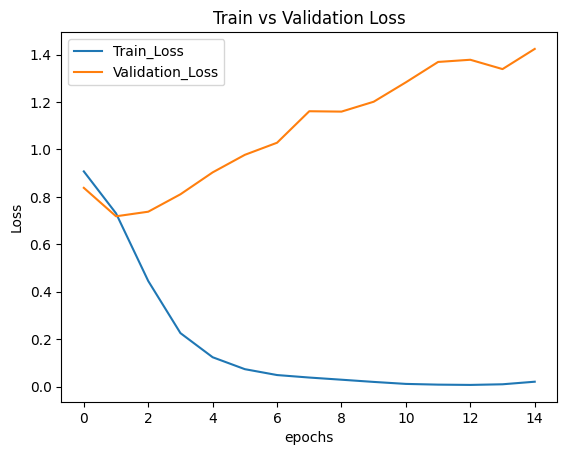

In [46]:
plt.plot(history.history["loss"], label = "Train_Loss")
plt.plot(history.history["val_loss"], label = "Validation_Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

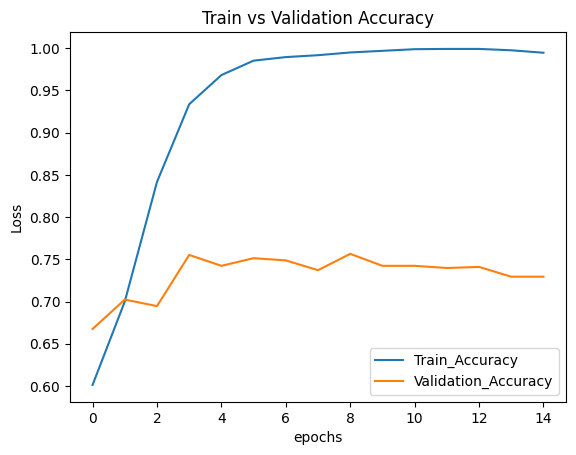

In [47]:
plt.plot(history.history["accuracy"], label = "Train_Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_Accuracy")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

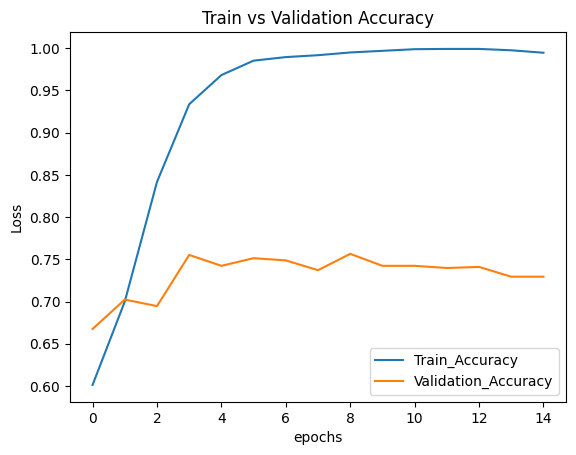

In [48]:
plt.plot(history.history["accuracy"], label = "Train_Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_Accuracy")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

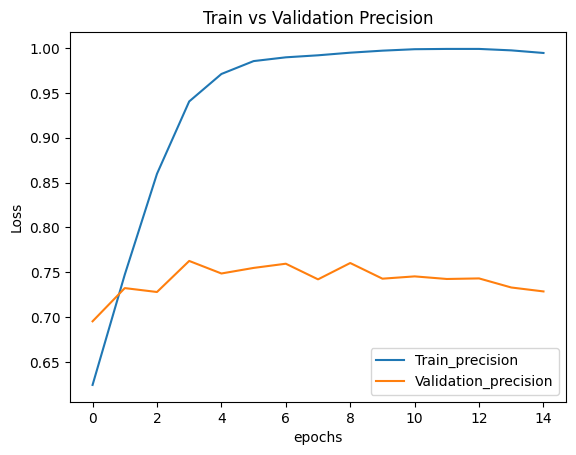

In [49]:
plt.plot(history.history["precision"], label = "Train_precision")
plt.plot(history.history["val_precision"], label = "Validation_precision")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Precision")
plt.legend()
plt.show()

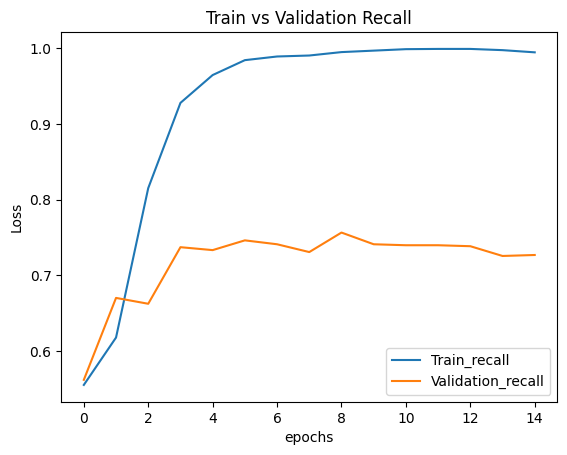

In [50]:
plt.plot(history.history["recall"], label = "Train_recall")
plt.plot(history.history["val_recall"], label = "Validation_recall")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Recall")
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

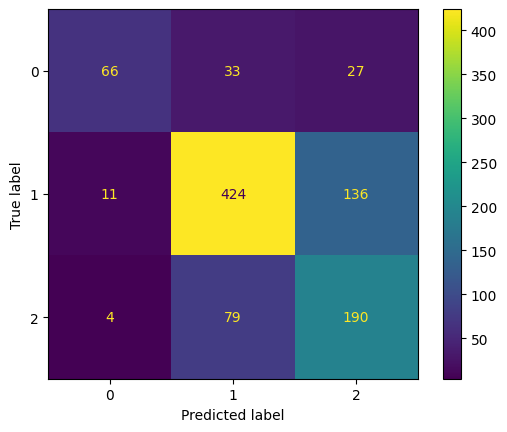

In [52]:
y_pred = np.argmax(pred, axis = 1)
y = np.argmax(y_test_best, axis = 1)

confusion_matrix_ = confusion_matrix(y, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = [0, 1, 2])
cm_display.plot()
plt.show() 